In [3]:
from slmfunctions.dependencies import *
from slmfunctions.settings import *
from slmfunctions.simulation import *
from slmfunctions.imageprocessing import *
from slmfunctions.phaseretrieval import *

## More dependencies
import scipy.fft as spfft
from scipy.ndimage import gaussian_filter1d as sp_gaussian_filter1d
from scipy.ndimage import affine_transform as sp_affine_transform
from scipy.ndimage import gaussian_filter as sp_gaussian_filter
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from itertools import product
 
cupyon=True

try:
    import cupy as cp
    import cupyx.scipy.fft as cpfft
    import cupyx.scipy.ndimage
    from cupyx.scipy.ndimage import gaussian_filter1d as cp_gaussian_filter1d
    from cupyx.scipy.ndimage import gaussian_filter as cp_gaussian_filter
    from cupyx.scipy.ndimage import affine_transform as cp_affine_transform
except ImportError:
    cp = np
    cpfft = spfft
    cp_gaussian_filter1d = sp_gaussian_filter1d
    cp_gaussian_filter = sp_gaussian_filter
    cp_affine_transform = sp_affine_transform
    cupyon = False
    print("cupy not installed. Using numpy.")

# GLOBAL VARIABLES
numpixels = 1300
slmwidth = 1200
slmheight = 1920


In [4]:
######### Optimized tweezer generator

### Settings
gpuoptimization = True
#Phase Offsets available: Off_None, Off_Rand, Off_Calc 
optimizedinitialguess = True # If this is true, then phase offset is on 
phaseoffset = Off_Rand
phaseoffsetoptimization = True
# #Phase optimizers available: Phase_MinJumps, Phase_MinAmp
phaseoffsetfunction = Phase_MinJumps
harmonicremoval = True
# #Cost Functions available: Pen_DeltaSqrt, Pen_Sqrt, Pen_Exp
gwscostfunction = Pen_DeltaSqrt
# #Error Metrics available: Err_MaxMinDiff, Err_Uniformity, Err_PowerEff
errormetric = Err_MaxMinDiff


focallength = 9.1 * 10**(-3) # mm
wavelength = 630 * 10**(-9)
pixelpitch = (8 * 200/250 * 10**(-6))# microns
slmaperture = pixelpitch * 1200
# Simulation Constants
numpix_frame = 1300
numpix_real = 4096
aperturesize_real = numpix_real * pixelpitch
aperturesize_fourier = wavelength * focallength / (pixelpitch)
pixelsize_fourier = aperturesize_fourier / numpix_real
print("Aod pixel pitch in microns: ", pixelpitch*1e6)
print("Fourier space spacing in microns: ", pixelsize_fourier*10**6)
print("Fourier space aperture in microns: ", aperturesize_fourier*10**6)

tweezerspacing = 9
numxtweezers = 30
numytweezers = 30

distancefromcenter = 72
centerwidth = 250
centerheight = 250
print("Tweezer spacing in microns: ", pixelsize_fourier*10**6 * tweezerspacing)
print("Offset of tweezers from center in microns: ", pixelsize_fourier*10**6 * distancefromcenter)
airydiskradius = 1.22 * wavelength * focallength / (pixelpitch*1200)
print(f"Airy disk radius is: {airydiskradius * 10**6} microns")

Aod pixel pitch in microns:  6.3999999999999995
Fourier space spacing in microns:  0.21869659423828125
Fourier space aperture in microns:  895.78125
Tweezer spacing in microns:  1.9682693481445312
Offset of tweezers from center in microns:  15.74615478515625
Airy disk radius is: 0.9107109375000002 microns


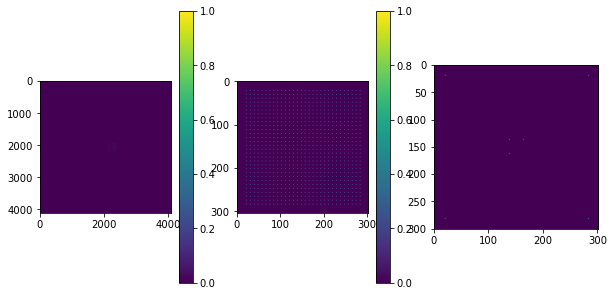

In [5]:

imgname = f"{numxtweezers}by{numytweezers}_{tweezerspacing}spacing_frame{numpix_frame}_real_{numpix_real}" # DEFINE NAME FIRST
tweezerarray = createtweezers_grid(cp.zeros((numpix_real,numpix_real)), tweezerspacing, numxtweezers, numytweezers, distancefromcenter )
anchorimg = createanchors(tweezerarray, tweezerspacing, magnification = 1.5)

sigma = airydiskradius / pixelsize_fourier / 16

tweezerarray = tweezerarray/cp.max(tweezerarray)
weightedtweezers, diffraction = applydiffractionlimited(tweezerarray, pixelsize_fourier , pixelpitch, wavelength, focallength)

gaussiantweezerarray = tocupy(apply_local_gaussian_filter(tonumpy(tweezerarray), sigma, tweezerspacing // 3))
gaussianweightedtweezers, diffraction = applydiffractionlimited(gaussiantweezerarray, pixelsize_fourier , pixelpitch, wavelength, focallength)


tweezerarray = tweezerarray / cp.max(tweezerarray)
weightedtweezers = weightedtweezers / cp.max(weightedtweezers)
gaussiantweezerarray = gaussiantweezerarray / cp.max(gaussiantweezerarray)
gaussianweightedtweezers = gaussianweightedtweezers / cp.max(gaussianweightedtweezers)

fig, axs = plt.subplots(1, 3, figsize=(10, 5))
im1 = axs[0].imshow(gaussianweightedtweezers.get(), cmap='viridis')
im2 = axs[1].imshow(zoomin(gaussianweightedtweezers).get())
im3 = axs[2].imshow(zoomin(anchorimg).get())
fig.colorbar(im1, ax=axs[0])
fig.colorbar(im2, ax=axs[1])

plt.show()


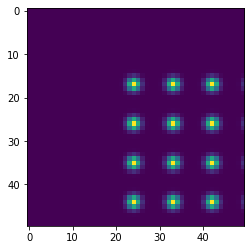

In [6]:
plt.imshow(gaussian_filter(gaussianweightedtweezers.get(),1)[1900:1950, 2100:2150])

In [7]:
def Pen_LukinGaussian(w,w_prev,target_im,std_int, harmonicremoval=False, harmoniccoords=[]):
    if harmonicremoval:
        w[target_im>threshold] = cp.sqrt((cp.mean(std_int[target_im>threshold]) / std_int[target_im>threshold])) * w_prev[target_im>threshold]
        w[harmoniccoords] = 0
    else:
        w[target_im>0] =  cp.sqrt(target_im[target_im>0] * (cp.mean(std_int[target_im>0]) / std_int[target_im>0])) * w_prev[target_im>0]
    return (w)


In [22]:
def derivephase_fixed_zeropadding(costfunction1, costfunction2, targetintensity2, initialphase, iterations1, iterations2, uniformtarget = 1, magnification = 1, harmonicremoval = False, badharmonics_pixelcoords=[], beamtype="Constant", custombeamamplitude = 1, sigma=1, mu = 1):
    """All inputs are assumed to be of the same dimensionality, 1300 by 1300. Note that magnification adds on to the target, so
    if target is already 3900 by 3900 magnification of 2 will make the simulation space much(!) larger. Beamtypes available are Gaussian or Constant."""
    # Remember, the calculation region is only numpixels by numpixels
    targetintensity = targetintensity2.copy()
    targetintensity_out = targetintensity2.copy()
    # targetintensity = targetintensity / cp.mean(targetintensity)
    # Just in case we're using a highly precise target (so not delta function)
    slmphase = set_circlemask(expand(initialphase, magnification), numpixels *magnification)
    inputbeam = set_circlemask(createbeam(beamtype, numpixels * magnification, sigma, mu), numpixels * magnification)
    outputbeam = set_circlemask(createbeam(beamtype, numpixels, sigma, mu), numpixels)


    if custombeamamplitude != 1:
        inputbeam = set_circlemask(custombeamamplitude, numpixels * magnification)
        outputbeam = inputbeam.copy()
    slmplane = join_phase_ampl(slmphase, inputbeam)
    slmplane = zeropad(slmplane, cp.shape(targetintensity)[0] - cp.shape(slmplane)[0])
    expandedsize = cp.shape(slmplane)[0]

    weights=cp.zeros((expandedsize, expandedsize), dtype = complex)
    weights_previous = targetintensity.copy()
    cutoff = cp.mean(targetintensity)
    # stdinttracker = [] # For use in error calculations
    tweezerlocation = cp.where(targetintensity > cutoff)
    err_maxmindiff = []
    err_uniformity = []
    err_powereff = []
    
    
    fourierplane = cp.fft.fftshift(cp.fft.fft2(cp.fft.fftshift(slmplane), norm="ortho"))
    fourierintensity = cp.square(cp.abs(fourierplane))
    stdint = cp.divide(fourierintensity, cp.max(fourierintensity))
    fourierangle = cp.angle(fourierplane)


    for _ in range(iterations1):
        startingpower = cp.sum(cp.abs(slmplane)**2)
        fourierplane = cp.fft.fftshift(cp.fft.fft2(cp.fft.fftshift(slmplane), norm="ortho"))
        fourierintensity = cp.square(cp.abs(fourierplane))
        stdint = cp.divide(fourierintensity, cp.max(fourierintensity))
        # stdint = fourierintensity
        if _ > 2:
            err_maxmindiff.append(Err_MaxMinDiff(stdint, tweezerlocation,targetintensity))
            err_uniformity.append(Err_Uniformity(stdint, tweezerlocation,targetintensity))
            err_powereff.append(Err_PowerEff(stdint, tweezerlocation))
        weights = costfunction1(weights, weights_previous, targetintensity, stdint, harmonicremoval, badharmonics_pixelcoords)
        weights_previous = weights.copy()
        ## This might be a bit confusing, but weights is now the amplitude and we re-combine it with the phase to get the next iteration
        fourierangle = cp.angle(fourierplane)
        fourierplane = join_phase_ampl(fourierangle, weights)
        slmplane = cp.fft.ifftshift(cp.fft.ifft2(cp.fft.ifftshift(fourierplane), norm="ortho"))     
        endingpower = cp.sum(cp.abs(slmplane)**2)
        slmplane = cp.multiply(cp.divide(slmplane, endingpower), startingpower)
        slmplane_numpixels = slmplane.copy()

        slmplane_numpixels = slmplane_numpixels[expandedsize//2- numpixels * magnification // 2:expandedsize//2+ numpixels * magnification // 2, expandedsize//2- numpixels * magnification // 2:expandedsize//2+ numpixels * magnification // 2]
        slmplane_numpixels = cp.mean(slmplane_numpixels.reshape(numpixels, magnification, numpixels, magnification), axis=(-3,-1))

        slmphase = undiscretize_phase(discretize_phase(set_circlemask(cp.angle(slmplane_numpixels), numpixels)))
        readout_slmphase = slmphase.copy()
        slmplane = join_phase_ampl(expand(slmphase, magnification), inputbeam)
        slmplane = zeropad(slmplane, cp.shape(targetintensity)[0] - cp.shape(slmplane)[0])

    weightsnew = cp.ones((expandedsize, expandedsize)) / 100
    weightsnew[targetintensity > 0] = weights[targetintensity>0]
    weights_previous = weightsnew

    for _ in range(iterations2):
        startingpower = cp.sum(cp.abs(slmplane)**2)
        fourierplane = cp.fft.fftshift(cp.fft.fft2(cp.fft.fftshift(slmplane), norm="ortho"))
        fourierintensity = cp.square(cp.abs(fourierplane))
        stdint = cp.divide(fourierintensity, cp.max(fourierintensity))
        # stdint = fourierintensity
        if _ > 0:
            err_maxmindiff.append(Err_MaxMinDiff(stdint, tweezerlocation, targetintensity))
            err_uniformity.append(Err_Uniformity(stdint, tweezerlocation, targetintensity))
            err_powereff.append(Err_PowerEff(stdint, tweezerlocation))

        weights = costfunction2(weights, weights_previous, targetintensity, stdint, harmonicremoval, badharmonics_pixelcoords)
        weights_previous = weights.copy()
        ## This might be a bit confusing, but weights is now the amplitude and we re-combine it with the phase to get the next iteration
        # fourierangle = cp.angle(fourierplane)
        currangle = cp.angle(fourierplane)
        anglediff = -fourierangle + currangle 
        fourierangle += (anglediff) / 100
        fourierplane = join_phase_ampl(fourierangle, weights)
        slmplane = cp.fft.ifftshift(cp.fft.ifft2(cp.fft.ifftshift(fourierplane), norm="ortho"))     
        endingpower = cp.sum(cp.abs(slmplane)**2)
        slmplane = cp.multiply(cp.divide(slmplane, endingpower), startingpower)
        slmplane_numpixels = slmplane.copy()
        slmplane_numpixels = slmplane_numpixels[expandedsize//2- numpixels * magnification // 2:expandedsize//2+ numpixels * magnification // 2, expandedsize//2- numpixels * magnification // 2:expandedsize//2+ numpixels * magnification // 2]
        slmplane_numpixels = cp.mean(slmplane_numpixels.reshape(numpixels, magnification, numpixels, magnification), axis=(-3,-1))

        slmphase = undiscretize_phase(discretize_phase(set_circlemask(cp.angle(slmplane_numpixels), numpixels)))
        readout_slmphase = slmphase.copy()
        slmplane = join_phase_ampl(expand(slmphase, magnification), inputbeam)
        slmplane = zeropad(slmplane, cp.shape(targetintensity)[0] - cp.shape(slmplane)[0])

    errors = [err_maxmindiff, err_uniformity, err_powereff]
    labels = ["MaxMinDiff","Uniformity", "Power Efficiency"]
    # inputbeam = cp.mean(inputbeam.reshape(numpixels, magnification, numpixels, magnification), axis=(-3,-1))
    # targetintensity = cp.mean(targetintensity.reshape(numpixels, magnification, numpixels, magnification), axis=(-3,-1))

    readout = OptimizedOutput()
    readout.set_all(readout_slmphase, fourierangle, weights, weights_previous, outputbeam, stdint, targetintensity_out, uniformtarget, errors, labels)
    
    return readout


In [23]:


randomguess = cp.random.rand(1300, 1300)
# Derive necessary phase for tweezers - fixed phase method
optimizedout_tweezer  = derivephase_fixed_zeropadding(Pen_LukinGaussian, Pen_LukinGaussian, gaussiantweezerarray, randomguess, 60, 20, uniformtarget=gaussiantweezerarray, magnification =1)

(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)

C:\Users\USER\AppData\Local\Temp/ipykernel_114300/4047793795.py:70: ComplexWarning: Casting complex values to real discards the imaginary part
  weightsnew[targetintensity > 0] = weights[targetintensity>0]


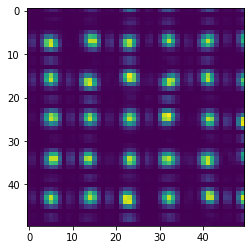

In [30]:
plt.imshow(optimizedout_tweezer.get_stdint().get()[2000:2050, 2200:2250])

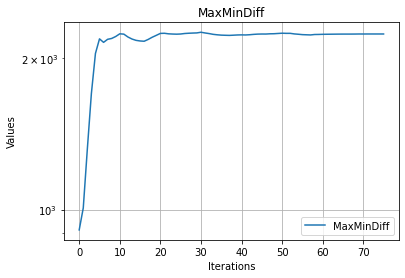

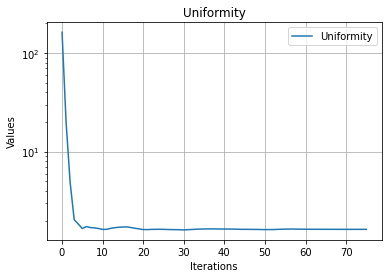

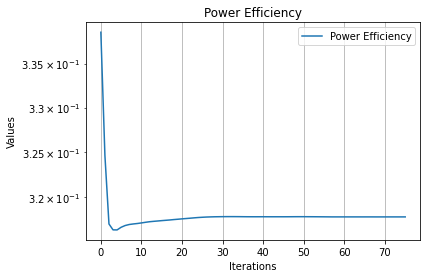

In [27]:
errors_thing = optimizedout_tweezer.get_all_errors()
labels_thing = optimizedout_tweezer.get_all_labels()

for i, label in enumerate(labels_thing): 
    plt.figure()
    plt.plot(errors_thing[i].get(), label=label)
    plt.yscale('log')  # Set y-axis to logarithmic scale
    plt.title(label)
    plt.legend()
    plt.xlabel('Iterations')
    plt.ylabel('Values')
    plt.grid(True)
    plt.show()

In [7]:
optimizedout_anchors = derivephase_fixed(Pen_Lukin, Pen_Lukin, anchorimg, randomguess, 60, 10, uniformtarget = anchorimg)

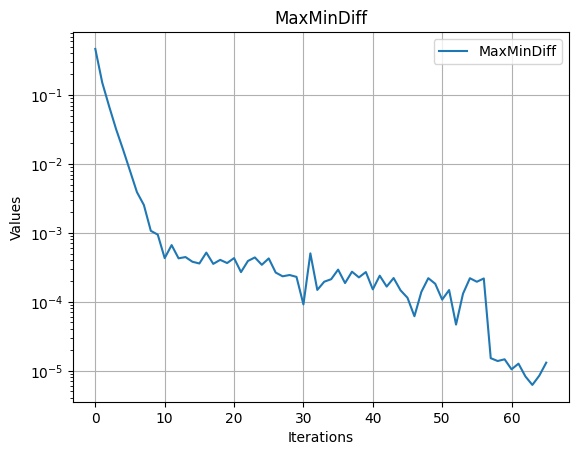

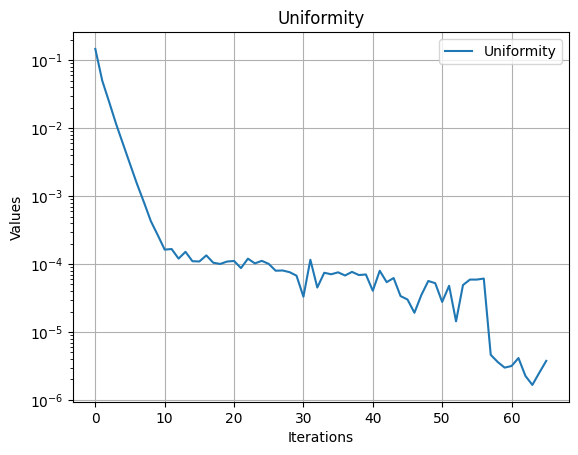

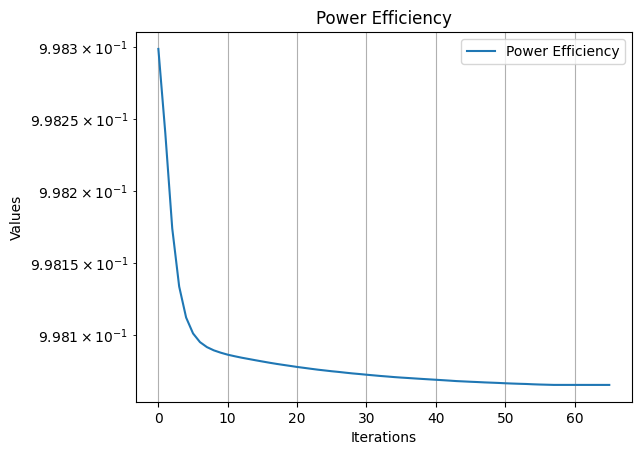

In [8]:
errors_thing = optimizedout_anchors.get_all_errors()
labels_thing = optimizedout_anchors.get_all_labels()

for i, label in enumerate(labels_thing): 
    plt.figure()
    plt.plot(errors_thing[i], label=label)
    plt.yscale('log')  # Set y-axis to logarithmic scale
    plt.title(label)
    plt.legend()
    plt.xlabel('Iterations')
    plt.ylabel('Values')
    plt.grid(True)
    plt.show()

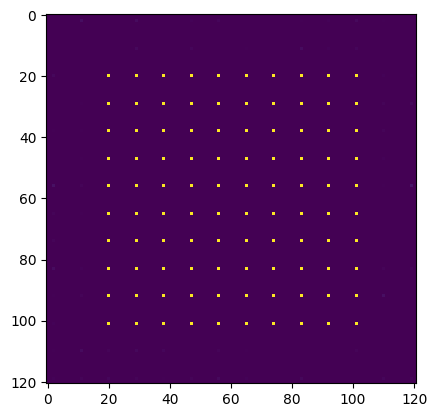

In [11]:
plt.imshow(zoomin(removeleftside((optimizedout_tweezer.get_stdint())), 10000))

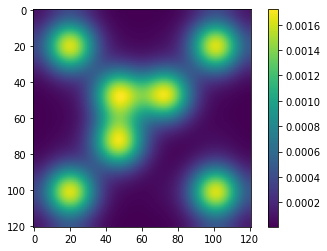

In [10]:
plt.imshow(gaussian_filter(zoomin(removeleftside(remove0thorder(optimizedout_anchors.get_stdint(),100),100), 1000000).get(),10))
plt.colorbar()

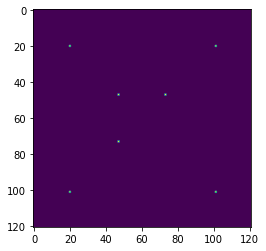

In [10]:
plt.imshow(zoomin(optimizedout_anchors.get_targetim()).get())

In [ ]:
# optimizedout_randguess  = derivephase(Pen_DeltaSqrt, tweezerarray, cp.random.rand(numpixels, numpixels), 100,1)
# kvector_initoffsets_none = Off_None(kvector_tweezers.get_magnitude(0), kvector_tweezers.get_angle(0), tweezerarray)
# initialphaseguess_nooffsets = create_phasemap(kvector_tweezers, kvector_initoffsets_none, wavetype=makesawtooth, opton=True, opttype=Phase_MinAmp, optiter=10)
# optimizedout_nooffsets  = derivephase(Pen_DeltaSqrt, tweezerarray, initialphaseguess_nooffsets, 1000,1)

In [17]:
# Convert to image files, and store!

# save_dir = r'Z:\nsong\NeutralAtoms\Ultracold-Research\GWS_Summer2024\storage'  # For PC
# save_dir = r'C:\cleen\nsong\2-Research\UAC Research\Github\Ultracold-Research\GWS_Summer2024\storage' # For laptop

# Local Laptop storage
save_dir = r'C:\cleen\nsong\2-Research\UAC Research\Github\ColdStorage'

def save_to_file(GWSclass, filepath, filename):
    os.makedirs(filepath, exist_ok=True)  # Create the directory if it doesn't exist
    phaseimg_path = os.path.join(filepath, f"{filename}_phase.bmp")
    
    # Check if GWSclass.get_slmphase() is numpy or cupy array
    if isinstance(GWSclass.get_slmphase(), np.ndarray):
        slm_phase = GWSclass.get_slmphase()[50:1250, :]
    else:
        slm_phase = GWSclass.get_slmphase().get()[50:1250, :]  # Assuming cupy array
    
    saver = np.zeros((1200, 1920))
    saver[0:1200, int(1920/2-sizepix/2):int(1920/2+sizepix/2)] = discretize_phase(slm_phase)
    phaseimg = Image.fromarray(saver).convert('RGB')
    phaseimg.save(phaseimg_path)

    filename = filename + ".pkl"
    with open(os.path.join(filepath, filename), 'wb') as file:
        pickle.dump(GWSclass, file)
    print(f"Object saved to {os.path.join(filepath, filename)}")

save_to_file(optimizedout_tweezer, save_dir, f'tweezers{imgname}')
optimizedout_tweezer = load_from_file(save_dir, f'tweezers{imgname}')
save_to_file(optimizedout_anchors, save_dir, f'anchors{imgname}')
optimizedout_anchors = load_from_file(save_dir, f'anchors{imgname}')

Object saved to C:\cleen\nsong\2-Research\UAC Research\Github\ColdStorage\tweezers10by10_9spacing_mag3grid.pkl
Object loaded from C:\cleen\nsong\2-Research\UAC Research\Github\ColdStorage\tweezers10by10_9spacing_mag3grid.pkl
Object saved to C:\cleen\nsong\2-Research\UAC Research\Github\ColdStorage\anchors10by10_9spacing_mag3grid.pkl
Object loaded from C:\cleen\nsong\2-Research\UAC Research\Github\ColdStorage\anchors10by10_9spacing_mag3grid.pkl


In [15]:
cp.min(discretize_phase(optimizedout_tweezer.get_slmphase()))

0.0

In [16]:
cp.max(discretize_phase(optimizedout_tweezer.get_slmphase()))

255.0

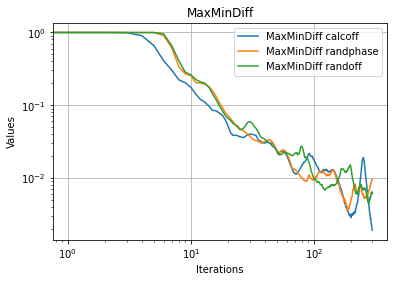

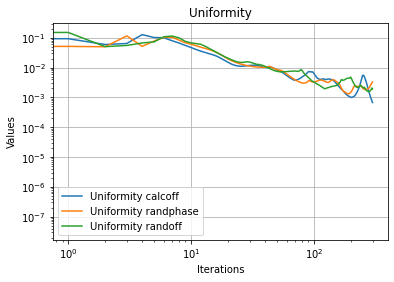

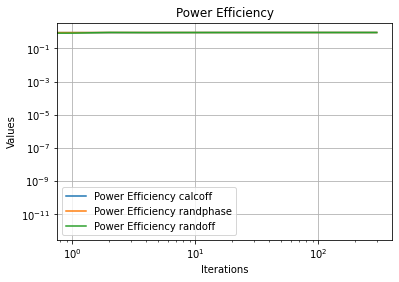

In [ ]:
errors = optimizedout.get_all_errors()
labels = optimizedout.get_all_labels()
errors_rand = optimizedout_randguess.get_all_errors()
labels_rand = optimizedout_randguess.get_all_labels()
errors_nooff = optimizedout_nooffsets.get_all_errors()
labels_nooff = optimizedout_nooffsets.get_all_labels()
for i, label in enumerate(labels):
    plt.figure()
    plt.loglog(errors[i].get(), label=str(cp.asnumpy(label))+" calcoff")
    plt.loglog(errors_rand[i].get(), label=str(cp.asnumpy(label))+" randphase")
    plt.loglog(errors_nooff[i].get(), label=str(cp.asnumpy(label))+" randoff")
    plt.title(label)
    plt.legend()
    plt.xlabel('Iterations')
    plt.ylabel('Values')
    plt.grid(True)
    plt.show()
